## Calculate gradients inside standard networks

__Note: This is a matlab notebook!__

You need to have both a valid matlab installation (2016a or newer) and the python package `matlab_kernel` installed. You also need to have SPM installed.

In the first cell, we transform all of the gradient files into the same voxel space as the standard network maps from neurosynth.

In [2]:
% list the correct files:
indivfiles = dir(fullfile(pwd, 'data', 'Outputs', 'individual', '*npy0.nii'));
network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));


In [4]:
%plot native
network_file = fullfile(pwd, 'ROIs_mask', network_files(1).name);

% transform into different voxel space
MatlabFuncs.progressbar(0);
for i = 1:numel(indivfiles)
    gradient_file = fullfile(pwd, 'data', 'Outputs', 'individual', indivfiles(i).name);
    if ~exist(fullfile([gradient_file(1:end-4), 'transformed.nii']))
            MatlabFuncs.Transform_into_the_same_voxelspace(network_file, gradient_file);
    end
    MatlabFuncs.progressbar(i/numel(indivfiles));
end

In the next cell, we use the different network files to calculate a goodness-of-fit (ratio between inside-of-the-network to outside-of-the-network).

In [5]:
%plot native
% define the inputs
mask_file = fullfile(pwd, 'ROIs_mask', 'rbgmask.nii');
network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));

% list the new, transformed files
transformfiles = dir(fullfile(pwd, 'data', 'Outputs', 'individual', '*transformed.nii'));

% reset the goodness of fit result
ratio = [];

MatlabFuncs.progressbar(0);
for inetwork = 1:numel(network_files)
    
    % define network file for this loop
    network_file = fullfile(pwd, 'ROIs_mask', network_files(inetwork).name);
    
    % loop over participants
    for i = 1:numel(transformfiles)
        % update a progbar
        MatlabFuncs.progressbar(((inetwork-1)*numel(transformfiles)+i)/(numel(transformfiles)*numel(network_files)));
        % define gradient for this loop
        gradient_file = fullfile(pwd, 'data', 'Outputs', 'individual', transformfiles(i).name);
        % run the goodness-of-fit analysis
        [ratio(inetwork, i)] = MatlabFuncs.gradient_goodness(gradient_file, network_file, mask_file);
    end
end


To avoid having to run everything _again_, we can save the ratio file to disk:

In [8]:
save(fullfile(pwd, 'data', 'ratios.mat'), 'ratio');

Now, make one big vector that indexes what group people are in

In [17]:
phenodata = readtable(fullfile(pwd, 'data', 'Outputs', 'Phenotypic_V1_0b_preprocessed1.csv'));
for i = 1:numel(transformfiles)
    [~, loc] = ismember(transformfiles(i).name(4:end-34), phenodata.FILE_ID(:));
    if loc
        group(i) = phenodata.DX_GROUP(loc);
    else
        group(i) = NaN;
    end
end


In the next cell, I create a boxplot that ranks the networks by fit

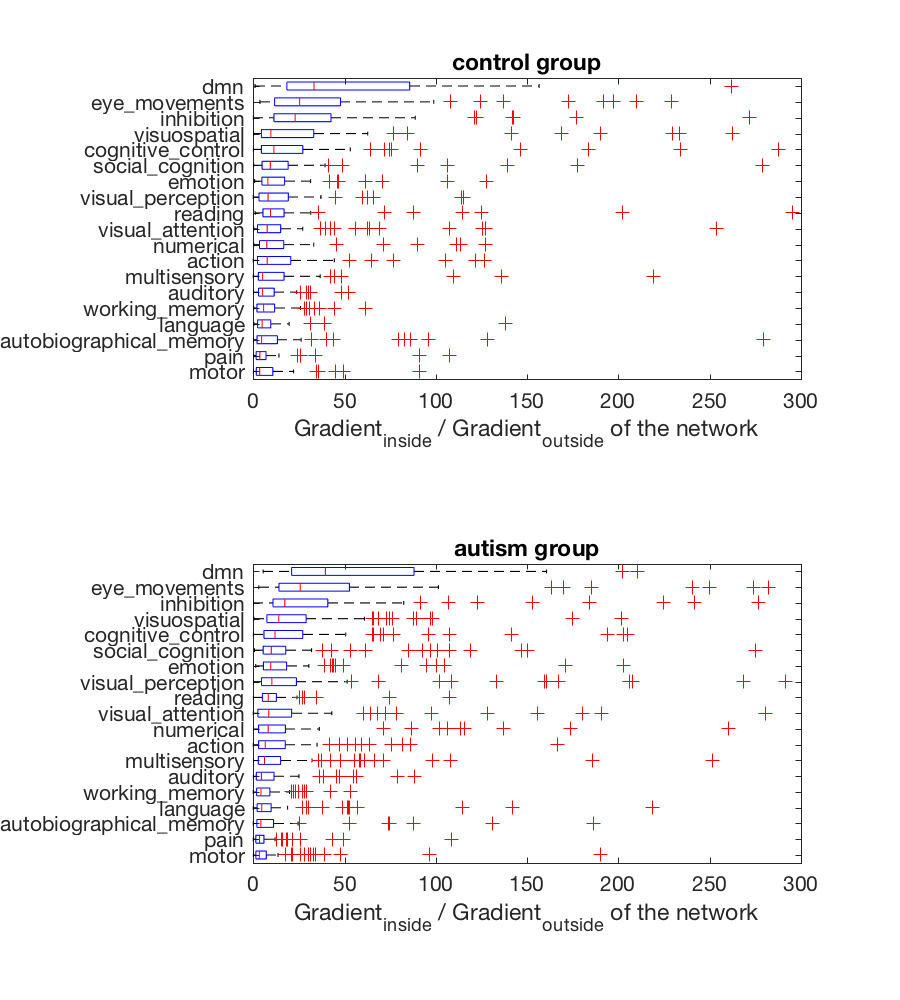

In [21]:
%plot inline -s 900,1000
network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));
[~, sortorder] = sort(median(ratio, 2));
figure;
labels = {network_files(:).name};
for i = 1:numel(labels)
    labels{i} = labels{i}(1:end-23);
end

grouplabels = {'control', 'autism'};
for igroup = 1:2
    subplot(2, 1, igroup);
    boxplot((ratio(sortorder, group==igroup)'), 'orientation', 'horizontal', 'Label', labels(sortorder));
    xlim([0, 300]);
    xlabel('Gradient_i_n_s_i_d_e / Gradient_o_u_t_s_i_d_e of the network');
    title([grouplabels{igroup}, ' group']);
end
% MatlabFuncs.xticklabel_rotate([1:inetwork],90,{network_files(:).name},'interpreter','none')

We can also do this for each bin of the gradient. The bin boundaries (in percentiles) can be given as a last argument to the gradient_goodness function. Note that this will roughly take 10x as long as the previous steps.

In [10]:
%plot native
% define the inputs
mask_file = fullfile(pwd, 'ROIs_mask', 'rbgmask.nii');
network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));

% list the new, transformed files
transformfiles = dir(fullfile(pwd, 'data', 'Outputs', 'individual', '*transformed.nii'));

% reset the goodness of fit result
binned_ratio = [];

MatlabFuncs.progressbar(0);
a = 0;
for inetwork = 1:numel(network_files)
    
    % define network file for this loop
    network_file = fullfile(pwd, 'ROIs_mask', network_files(inetwork).name);
    
    % loop over participants
    for i = 1:numel(transformfiles)
            % update a progbar
            a = a+1;
            MatlabFuncs.progressbar(a/(numel(network_files)*numel(transformfiles)));
            % define gradient for this loop
            gradient_file = fullfile(pwd, 'data', 'Outputs', 'individual', transformfiles(i).name);
            % run the goodness-of-fit analysis
            [binned_ratio(inetwork, i, 1:10)] = MatlabFuncs.gradient_goodness(gradient_file, network_file, mask_file, true);
    end
end


Since this takes for-absolutely-ever, we should save this file so that we don't have to repeat anything!

In [11]:
save(fullfile(pwd, 'data', 'binned_ratios.mat'), 'binned_ratio');

In [14]:
load(fullfile(pwd, 'data', 'binned_ratios.mat'));

We can also do the same visualisation as above for these binned results

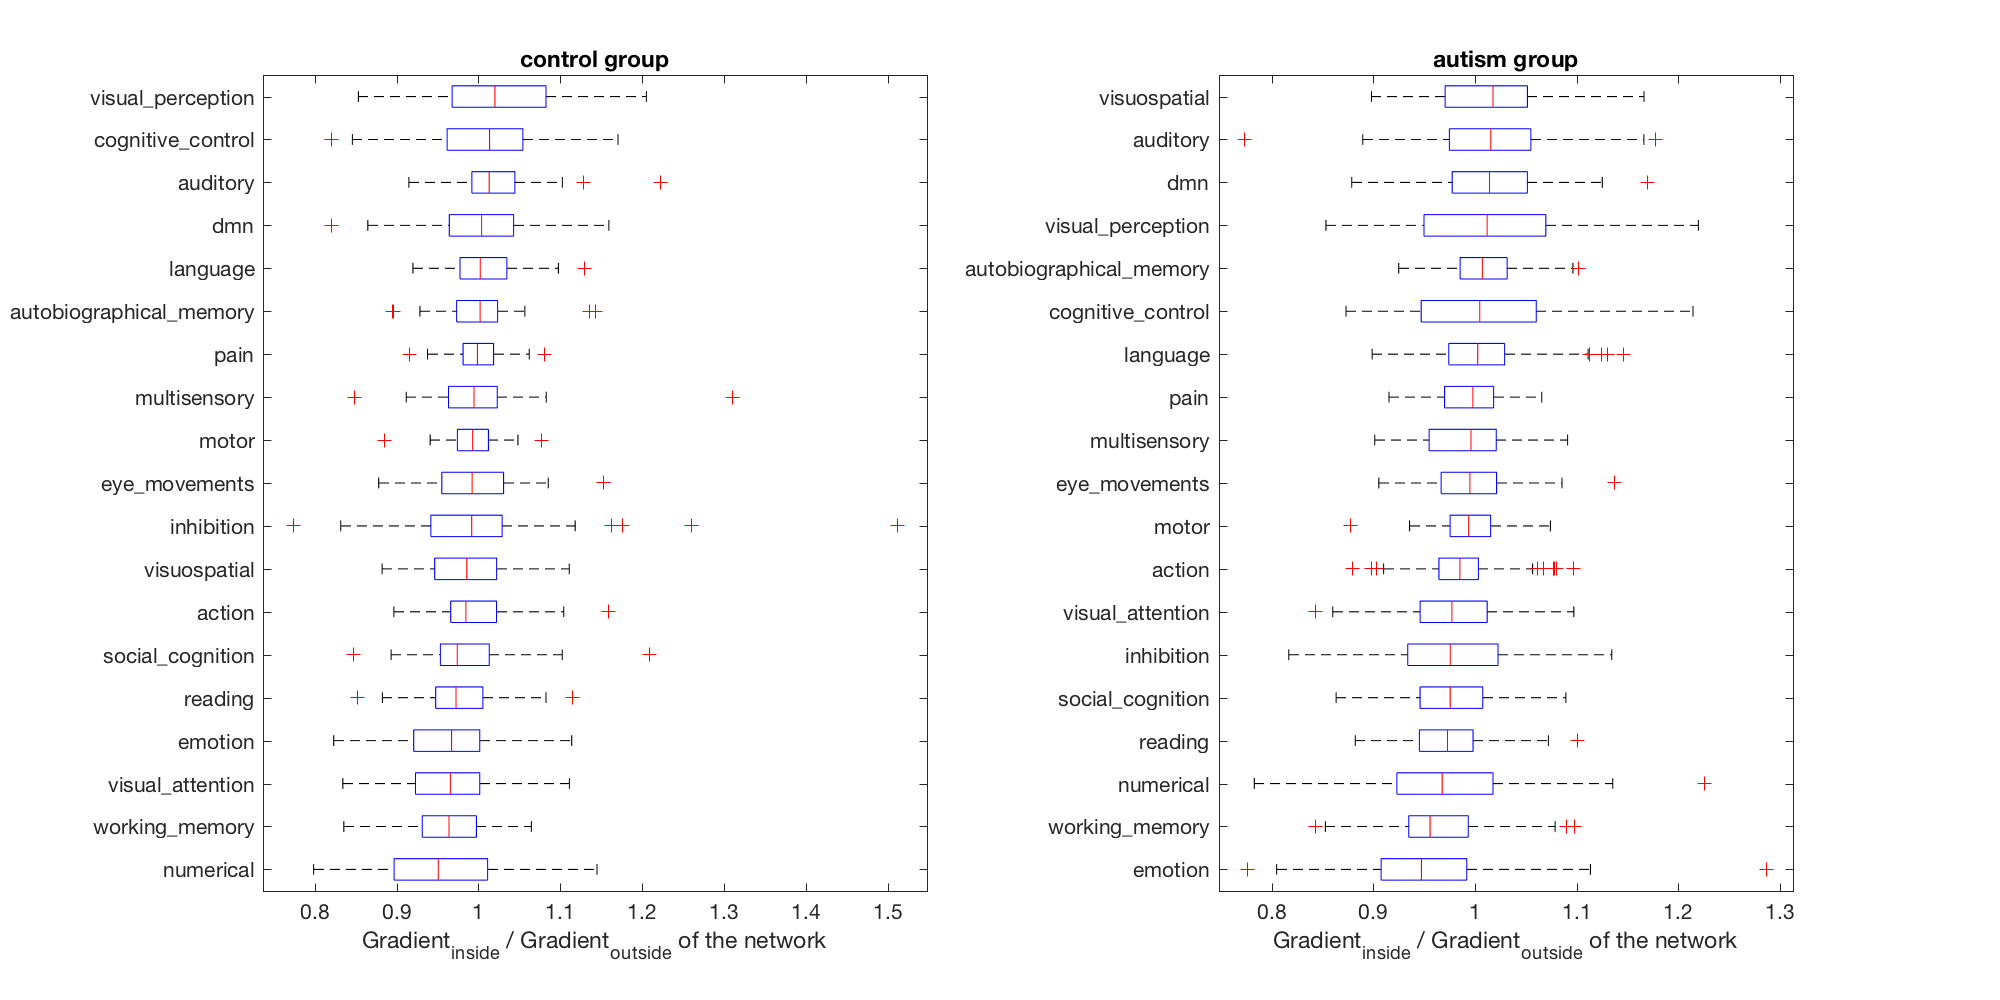

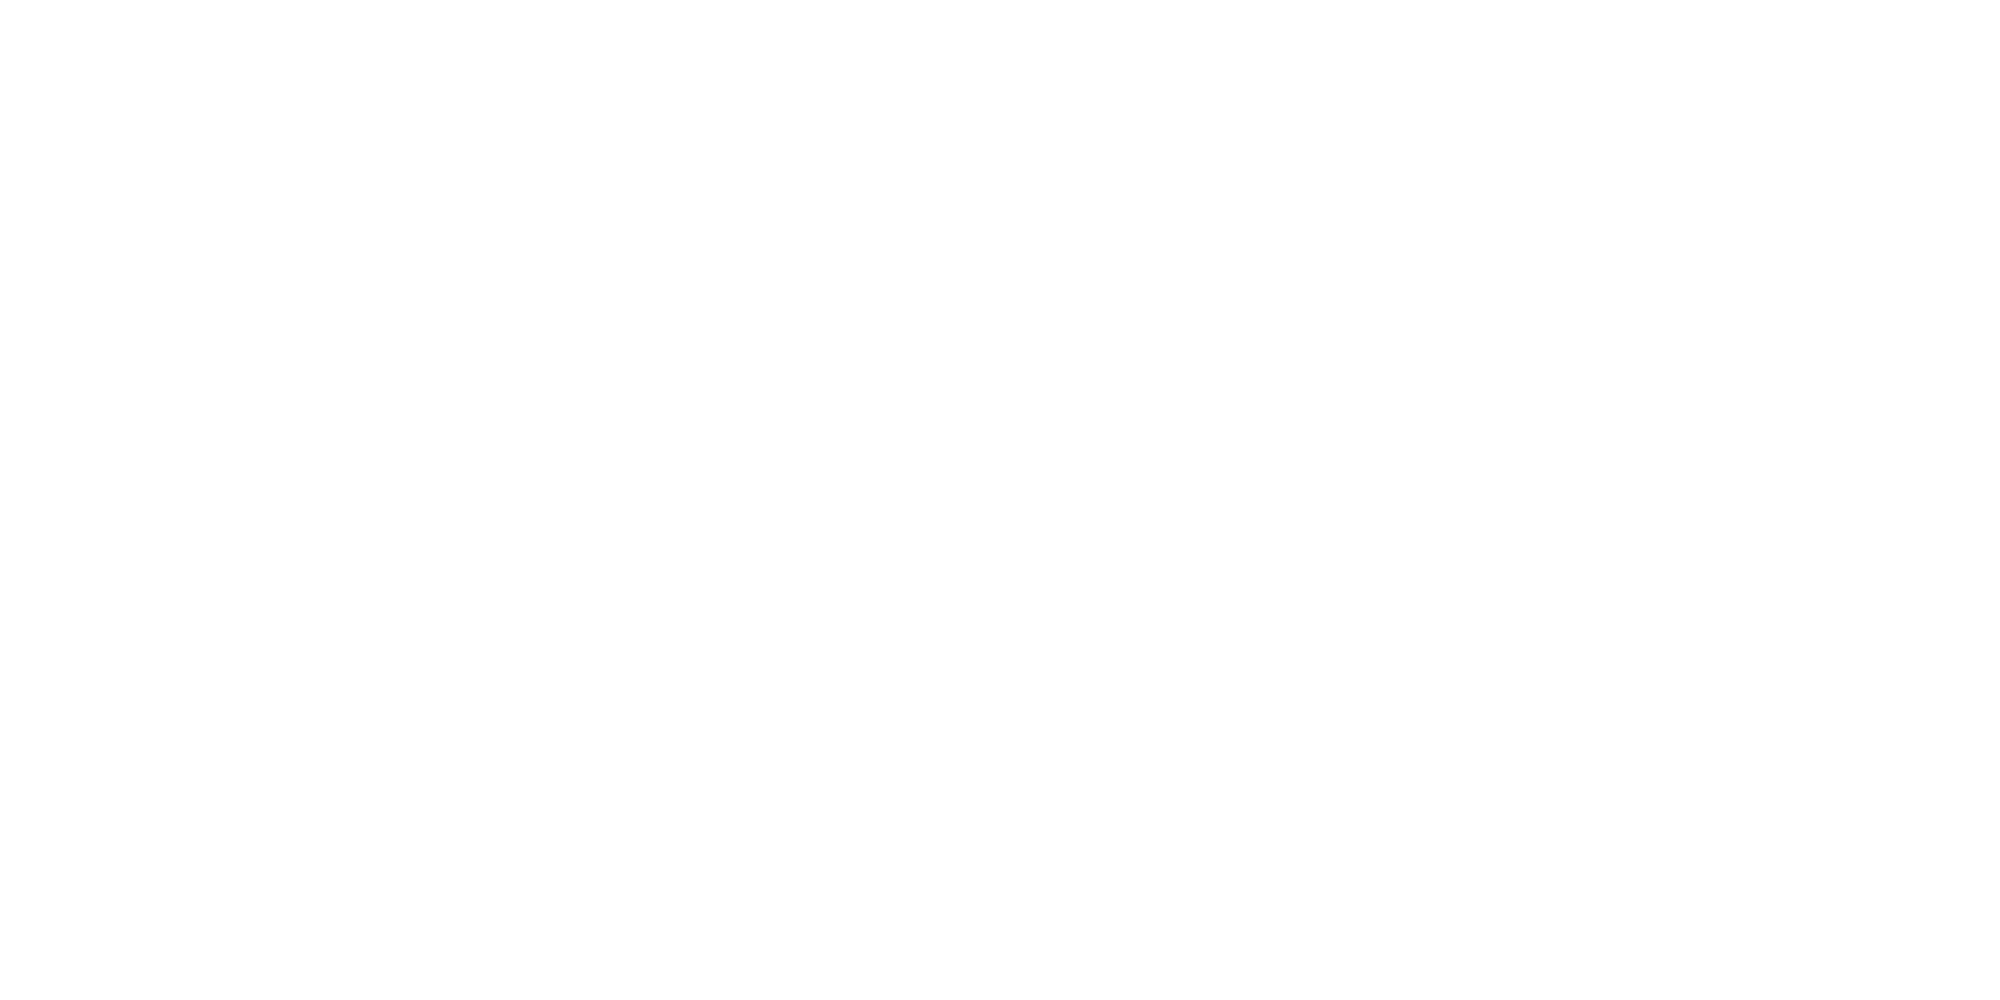

Columns 1 through 7

    0.9410    0.9836    0.9496    0.9452    1.0110    0.9753    1.0224
    0.9590    1.0113    0.9206    0.9472    0.9927    1.0654    0.9856
    0.9481    0.9488    1.0225    1.0494    0.9598    0.9968    1.0671
    0.9843    1.0370    0.9569    0.9854    1.0216    0.9691    1.0070
    1.0390    1.0107    0.9450    0.9092    0.9613    0.9554    0.9536
    0.8369    0.8984    0.8849    0.9142    0.9478    0.9700    0.9328
    1.0112    0.9989    1.0131    0.9479    0.9984    0.9819    1.0193
    0.9198    0.9301    0.9986    0.9637    1.0304    0.9568    1.0220
    0.9307    0.9759    1.0557    0.9670    0.9843    1.0265    1.0684
    1.1448    1.0647    1.0054    0.9934    1.0478    0.9593    0.9548
    0.9015    0.9566    0.9703    1.1139    0.9305    0.9720    0.8967
    0.8437    0.9769    0.9479    0.9984    1.0054    0.9788    1.0115
    0.8234    0.9280    0.9231    1.0750    0.9490    0.9619    0.9827
    1.0364    0.9771    1.0050    0.8957    1.0066    1.

In [33]:
%plot inline -s 2000,1000
% network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));
figure;
labels = {network_files(:).name};
for i = 1:numel(labels)
    labels{i} = labels{i}(1:end-23);
end

grouplabels = {'control', 'autism'};

for ibin = 1
figure;
for igroup = 1:2
    
    subplot(1, 2, igroup);
    
    [~, sortorder] = sort(median(binned_ratio(:, group==igroup, ibin), 2));
    disp(binned_ratio(sortorder, group==igroup, ibin)');
    
    boxplot(squeeze(binned_ratio(sortorder, group==igroup, ibin))', 'orientation', 'horizontal', 'Labels', labels(sortorder));
    % xlim([0, 300]);
    xlabel('Gradient_i_n_s_i_d_e / Gradient_o_u_t_s_i_d_e of the network');
    title([grouplabels{igroup}, ' group']);
end
end
